# <h1 style="text-align: center; color:magenta"> Prediction Section </h1>

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, f1_score, accuracy_score, precision_recall_curve

## <h2 style="text-align: left; color:cyan"> Loading Data </h2>

Load data from the prepared file

In [119]:
df = pd.read_pickle("prediction_features_df.pkl")

## <h2 style="text-align: left; color:cyan"> Preprocessing & Feature Engineering </h2>
Some features such as member count, transport insurance and vehicle expenses and mean_age of the family, living in urban/rural neighborhood were created in the previous secion, i.e. the sheet loading section.

In [120]:
# Storing the info of the original dataframe
import io
buffer = io.StringIO()
df.info(buf=buffer)
info_lines = buffer.getvalue().splitlines()
original_info_df = (pd.DataFrame([x.split() for x in info_lines[5:-2]], columns=info_lines[3].split())
       .drop(["#",'Count'],axis=1)
       .rename(columns={'Non-Null':'Non-Null Count'})
       .astype({"Non-Null Count":int}))
original_info_df.sort_values(by="Non-Null Count", ascending=False)

,Column,Non-Null Count,Dtype
0,Address,151824,int64
6,member_cnt,151824,int64
13,bicycle,151824,bool
12,motorcycle,151824,bool
1,Urban,151824,bool
8,mean_age,151824,float64
11,vehicle,151824,bool
5,town,151824,int64
4,province,151824,object
3,khanevartype,151824,int64


We fill the NaN values of some features with few NaN count with zero, only the ones that make sense to do so, for features with many NaN values, we store their column names and decide later to be included in our model features or not.

In [121]:
df.subsidy.fillna(0, inplace=True)
df.transportation_cost.fillna(0, inplace=True)
df.misc_income.fillna(0, inplace=True)
df.active_member_cnt.fillna(0, inplace=True)

# columns with more than half of the data being null
df.netincome_w_y.fillna(0, inplace=True)
df.vehicle_expenses.fillna(0, inplace=True)
df.income_s_y.fillna(0, inplace=True)
df.transport_insurance_expenses.fillna(0, inplace=True)
df.highly_educated_member_cnt.fillna(0, inplace=True)
df.dining_expenses.fillna(0, inplace=True)

In [125]:
df["total_income"] = df.netincome_w_y + df.income_s_y + df.subsidy + df.misc_income
df = df.drop(columns=["netincome_w_y", "income_s_y", "subsidy", "misc_income"])

In [130]:
df.loc[df.total_income<0, :]

,Address,Urban,Year,khanevartype,province,town,member_cnt,active_member_cnt,mean_age,highly_educated_member_cnt,tenure,vehicle,motorcycle,bicycle,transportation_cost,dining_expenses,transport_insurance_expenses,vehicle_expenses,total_income
2049,20310420527,False,1400,1,AzarbaijanSharghi,10,2,1.0,81.000000,0.0,OwnedEstateLand,True,False,False,1250000.0,0.0,30000000.0,1500000.0,-1.124000e+08
7277,21020513620,False,1400,1,Esfahan,20,4,2.0,39.500000,0.0,OwnedEstateLand,False,True,False,2550000.0,0.0,0.0,16000000.0,-2.716400e+08
8082,21202529429,False,1400,1,Kordestan,2,5,3.0,28.200000,0.0,OwnedEstateLand,False,True,False,4000000.0,1600000.0,0.0,0.0,-1.960000e+06
8394,21301535635,False,1400,1,Hamedan,1,2,1.0,51.500000,0.0,OwnedEstateLand,True,True,False,1200000.0,0.0,6500000.0,43350000.0,-3.564540e+08
8651,21305540425,False,1400,1,Hamedan,5,4,1.0,20.750000,0.0,OwnedEstateLand,False,False,False,400000.0,0.0,0.0,0.0,-4.441200e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8065,11303162929,True,1399,1,Hamedan,3,3,1.0,15.666667,0.0,Rent,False,True,False,3200000.0,0.0,0.0,200000.0,-8.711500e+07
8342,11307169426,True,1399,1,Hamedan,7,3,1.0,20.666667,0.0,OwnedEstateLand,False,True,False,4500000.0,2000000.0,0.0,12000000.0,-4.383100e+08
8551,11402173817,True,1399,1,CharmahalBakhtiari,2,4,4.0,35.250000,1.0,Mortgage,True,False,True,1210000.0,0.0,8000000.0,8350000.0,-4.382400e+08
12508,12105245823,True,1399,1,Yazd,5,1,1.0,24.000000,1.0,Rent,False,False,False,5000000.0,3000000.0,0.0,0.0,-1.220000e+09


['OwnedEstateLand' 'Free' 'Rent' 'Mortgage' 'Service' 'OwnedEstate'
 'Other' nan]
           Address  Urban  Year  khanevartype province  town  member_cnt  \
3487   20815486435  False  1401             1   Kerman    15           1   
18260  20816486733  False  1401             1   Kerman    16           4   
3532   10812104227   True  1401             1   Kerman    12           6   
3538   10815104627   True  1401             1   Kerman    15           4   

       active_member_cnt   mean_age  highly_educated_member_cnt tenure  \
3487                 0.0  99.000000                         0.0    NaN   
18260                1.0  35.250000                         0.0    NaN   
3532                 1.0  24.666667                         0.0    NaN   
3538                 2.0  23.250000                         0.0    NaN   

       vehicle  motorcycle  bicycle  transportation_cost  dining_expenses  \
3487     False       False    False             800000.0              0.0   
18260    Fal

array([[<Axes: title={'center': 'Year'}>]], dtype=object)

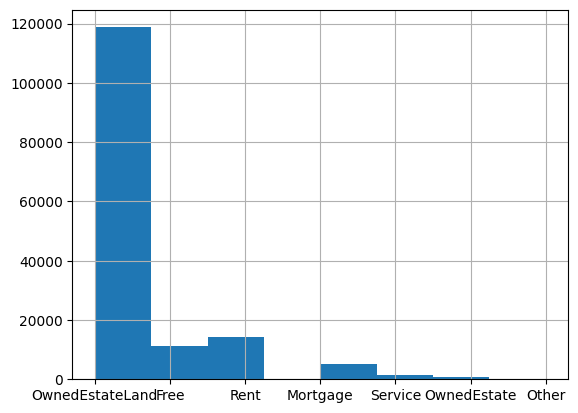

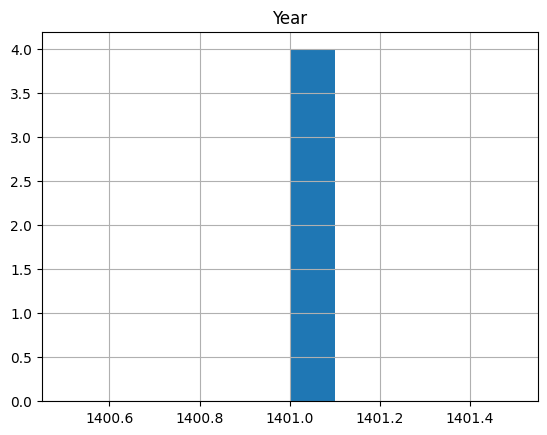

In [131]:
col = "tenure"
print(df[col].unique())
print(df.loc[df[col].isna(), :])
df[col].hist(bins=len(df[col].unique()))
df.loc[df[col].isna(), ["Year"]].hist()